In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates

import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib.colors import LogNorm

from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.ticker                         # here's where the formatter is
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from astropy.visualization import (MinMaxInterval, SqrtStretch,ZScaleInterval,PercentileInterval,
                                   ImageNormalize,imshow_norm)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch


from astropy.io import fits




In [2]:
# Assembly task
# https://github.com/lsst/ip_isr/blob/main/python/lsst/ip/isr/isrTask.py

from lsst.ip.isr.assembleCcdTask import (AssembleCcdConfig, AssembleCcdTask)
from lsst.ip.isr.isrTask import (IsrTask, IsrTaskConfig)

#https://github.com/lsst/ip_isr/blob/main/python/lsst/ip/isr/overscan.py
from lsst.ip.isr import  OverscanCorrectionTaskConfig, OverscanCorrectionTask

In [3]:
# LSST Display
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('matplotlib')

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
! eups list -s

afw                   g4728e35f0d+53a8438ab4 	current w_2023_38 setup
alert_packet          g6041bd2d66 	current w_2023_38 setup
analysis_drp          g8a53795882+8240499edc 	current w_2023_38 setup
analysis_tools        g1887775915+c89e410209 	current w_2023_38 setup
ap_association        g6a6fcd37b7+f81e0a4cd9 	current w_2023_38 setup
ap_pipe               g06c608b3b8+0cce5f0898 	current w_2023_38 setup
ap_verify             gf37a9491f6+9462b9949d 	current w_2023_38 setup
astro_metadata_translator g0978aabd1f+0ce179faa8 	current w_2023_38 setup
astshim               g3273194fdb+f6908454ef 	current w_2023_38 setup
atmospec              LOCAL:/home/m/monroy/repos/repos_w_2023_35/atmospec 	setup
base                  g98ffbb4407+81bc2a20b4 	current w_2023_38 setup
cbp                   ga32fcf49c8+387721ca5c 	current w_2023_38 setup
cell_coadds           g9faf7ed3f3+8240499edc 	current w_2023_38 setup
coadd_utils           g337abbeb29+387721ca5c 	current w_2023_38 setup
cp_pipe         

# Butler 

In [6]:
import lsst.daf.butler as dafButler

In [7]:
embargo = True

In [8]:
if embargo:
    repo="/sdf/group/rubin/repo/oga/"
else:
    repo = "/sdf/group/rubin/repo/main"
butler = dafButler.Butler(repo)
registry = butler.registry

In [9]:
cameraName = 'LATISS'
calibCollections = ['LATISS/defaults','LATISS/raw/all']
for col in registry.queryCollections("*LATISS/calib*"):
    #print(col)
    calibCollections.append(col)

# Paths 

In [10]:
outdir_base = 'output_fits/'
if os.path.exists(outdir_base)==False:
    os.mkdir(outdir_base)
outdir_label = 'regular_flat_{0}/'

We check the different dimension records existing for *physical_filter*: 

In [11]:
phys_filters = list(registry.queryDimensionRecords('physical_filter',where="instrument='LATISS'"))

Print physical_filters with hologram in place: 

In [12]:
for f_ in phys_filters:
    if 'holo' in f_.name:
        print(f_.name)

empty~holo4_003
blank_bk7_wg05~holo4_003
KPNO_1111_436nm~holo4_003
KPNO_373A_677nm~holo4_003
KPNO_406_828nm~holo4_003
unknown~holo4_003
BG40~holo4_003
quadnotch1~holo4_003
RG610~holo4_003
FELH0600~holo4_003
SDSSg~holo4_003
SDSSr~holo4_003
SDSSi~holo4_003
BG40_65mm_1~holo4_003
BG40_65mm_2~holo4_003
OG550_65mm_1~holo4_003
OG550_65mm_2~holo4_003
SDSSg_65mm~holo4_003
SDSSr_65mm~holo4_003
SDSSi_65mm~holo4_003
SDSSu_65mm~holo4_003
SDSSz_65mm~holo4_003
SDSSy_65mm~holo4_003
empty~holo4_001
blank_bk7_wg05~holo4_001
KPNO_1111_436nm~holo4_001
KPNO_373A_677nm~holo4_001
KPNO_406_828nm~holo4_001
unknown~holo4_001
BG40~holo4_001
BG40_65mm_1~holo4_001
BG40_65mm_2~holo4_001
quadnotch1~holo4_001
RG610~holo4_001
OG550_65mm_1~holo4_001
OG550_65mm_2~holo4_001
FELH0600~holo4_001
SDSSg~holo4_001
SDSSr~holo4_001
SDSSi~holo4_001
SDSSu_65mm~holo4_001
SDSSg_65mm~holo4_001
SDSSr_65mm~holo4_001
SDSSi_65mm~holo4_001
SDSSz_65mm~holo4_001
SDSSy_65mm~holo4_001
collimator~holo4_003
collimator~holo4_001
cyl_lens~holo4_0

In [13]:
obs_type = 'flat'
physical_filter = 'empty~empty' 

In [14]:
df_science = pd.DataFrame(columns=['id', 'obs_id','day_obs', 'seq_num','time_start',
                                    'time_end' ,'type', 'target','filter_disp','zenith_angle',
                                    'exp_time','ra','dec','skyangle','science_program'])

In [15]:

#where_exps = "instrument='LATISS' AND exposure.observation_type='{0}' AND exposure.day_obs={1} AND physical_filter='{2}'".format(obs_type,obs_day,physical_filter)
where_exps = "instrument='LATISS' AND exposure.observation_type='{0}'".format(obs_type)
for i, info in enumerate(registry.queryDimensionRecords('exposure',where=where_exps)):
    
    #if info.observation_type=='science':
    id_ = info.id
    obs_id_ = info.obs_id
    day_obs_ = info.day_obs
    seq_num_ = info.seq_num
    timespan_ = info.timespan
    timespan_begin_ = pd.to_datetime(timespan_.begin.to_string())
    timespan_end_ = pd.to_datetime(timespan_.end.to_string())
    timespan_begin_jd_ = timespan_.begin.jd
    timespan_begin_mjd_ = timespan_.begin.mjd

    observation_type_ = info.observation_type
    target_name_ = info.target_name
    physical_filter_ = info.physical_filter
    zenith_angle_ = info.zenith_angle
    exposure_time_ = info.exposure_time
    tracking_ra_ = info.tracking_ra
    tracking_dec_ = info.tracking_dec
    sky_angle_ = info.sky_angle
    science_program_ = info.science_program

    df_science.loc[i] = [id_, obs_id_, day_obs_, seq_num_,timespan_begin_,timespan_end_ ,observation_type_, \
                         target_name_, physical_filter_, zenith_angle_, exposure_time_,tracking_ra_, \
                         tracking_dec_, sky_angle_, science_program_]

    if i < 2:
        print(i)
        print(info)
        print("\t timespan:            ",info.timespan)
        print("\t timespan.begin:      ",info.timespan.begin)
        print("\t id:                  ",info.id)
        print("\t day_obs:             ",info.day_obs)
        print("\t seq_num:             ",info.seq_num)
        print("\t type-of-observation: ",info.observation_type)
        print("\t target:              ",info.target_name)
        print("-----------------------------------------------------")
    

0
exposure:
  instrument: 'LATISS'
  id: 2022090200006
  physical_filter: 'unknown~unknown'
  obs_id: 'AT_O_20220902_000006'
  exposure_time: 2.0
  dark_time: 2.23911
  observation_type: 'flat'
  observation_reason: 'flat'
  day_obs: 20220902
  seq_num: 6
  seq_start: 6
  seq_end: 6
  group_name: '2022090200006'
  group_id: 2022090200006
  target_name: 'UNKNOWN'
  science_program: 'unknown'
  tracking_ra: None
  tracking_dec: None
  sky_angle: None
  azimuth: None
  zenith_angle: None
  has_simulated: False
  timespan: Timespan(begin=astropy.time.Time('2022-09-02 19:41:26.805005', scale='tai', format='iso'), end=astropy.time.Time('2022-09-02 19:41:29.045000', scale='tai', format='iso'))
	 timespan:             [2022-09-02T19:41:26.805005, 2022-09-02T19:41:29.045000)
	 timespan.begin:       2022-09-02 19:41:26.805005
	 id:                   2022090200006
	 day_obs:              20220902
	 seq_num:              6
	 type-of-observation:  flat
	 target:               UNKNOWN
--------------

In [16]:
print('Number of entries = ',len(df_science))

Number of entries =  6143


In [17]:
df_science.tail(5)

,id,obs_id,day_obs,seq_num,time_start,time_end,type,target,filter_disp,zenith_angle,exp_time,ra,dec,skyangle,science_program
6138,2023092600431,AT_O_20230926_000431,20230926,431,2023-09-26 20:30:21.954001,2023-09-26 20:30:34.992,flat,FlatField position,SDSSr_65mm~empty,51.043563,12.8,204.262907,-78.589613,None,unknown
6139,2023092600432,AT_O_20230926_000432,20230926,432,2023-09-26 20:30:37.483992,2023-09-26 20:30:50.517,flat,FlatField position,SDSSr_65mm~empty,51.043565,12.8,204.329052,-78.589666,None,unknown
6140,2023092600433,AT_O_20230926_000433,20230926,433,2023-09-26 20:30:53.008993,2023-09-26 20:31:06.037,flat,FlatField position,SDSSr_65mm~empty,51.043567,12.8,204.391070,-78.589723,None,unknown
6141,2023092600434,AT_O_20230926_000434,20230926,434,2023-09-26 20:31:08.522005,2023-09-26 20:31:21.556,flat,FlatField position,SDSSr_65mm~empty,51.043562,12.8,204.457226,-78.589780,None,unknown
6142,2023092600435,AT_O_20230926_000435,20230926,435,2023-09-26 20:31:24.049018,2023-09-26 20:31:37.079,flat,FlatField position,SDSSr_65mm~empty,51.043566,12.8,204.519221,-78.589835,None,unknown


Available dates: 

In [18]:
obs_year = 2023

In [19]:
obs_days_ = np.unique(np.sort(np.array(df_science.day_obs)))
obs_days = obs_days_[obs_days_>=int(str(obs_year)+'0101')]
print(obs_days)

[20230110 20230112 20230116 20230117 20230118 20230119 20230127 20230131
 20230201 20230202 20230207 20230209 20230214 20230215 20230216 20230301
 20230311 20230314 20230321 20230327 20230404 20230420 20230425 20230427
 20230502 20230505 20230509 20230510 20230511 20230522 20230523 20230524
 20230525 20230704 20230705 20230706 20230718 20230719 20230720 20230724
 20230725 20230726 20230727 20230801 20230802 20230803 20230811 20230816
 20230817 20230822 20230823 20230829 20230830 20230911 20230912 20230913
 20230921 20230926]


Select date: 

In [20]:
obs_day = 20230926
df_selected = df_science[df_science.day_obs==obs_day]

Select exposures: 

In [21]:
seq_nums = np.sort(np.array(df_selected.seq_num))
print(seq_nums)

[295 296 297 298 299 300 301 302 303 304 305 306 307 308 309 310 311 312
 313 314 315 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338
 339 340 341 342 343 344 353 354 355 356 357 358 359 360 361 362 363 364
 365 366 367 368 369 370 371 372 373 374 375 376 377 378 379 380 381 382
 383 384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400
 401 402 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417 418
 419 420 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435]


In [22]:
ids = np.sort(np.array(df_selected.id))
print(ids)

[2023092600295 2023092600296 2023092600297 2023092600298 2023092600299
 2023092600300 2023092600301 2023092600302 2023092600303 2023092600304
 2023092600305 2023092600306 2023092600307 2023092600308 2023092600309
 2023092600310 2023092600311 2023092600312 2023092600313 2023092600314
 2023092600315 2023092600324 2023092600325 2023092600326 2023092600327
 2023092600328 2023092600329 2023092600330 2023092600331 2023092600332
 2023092600333 2023092600334 2023092600335 2023092600336 2023092600337
 2023092600338 2023092600339 2023092600340 2023092600341 2023092600342
 2023092600343 2023092600344 2023092600353 2023092600354 2023092600355
 2023092600356 2023092600357 2023092600358 2023092600359 2023092600360
 2023092600361 2023092600362 2023092600363 2023092600364 2023092600365
 2023092600366 2023092600367 2023092600368 2023092600369 2023092600370
 2023092600371 2023092600372 2023092600373 2023092600374 2023092600375
 2023092600376 2023092600377 2023092600378 2023092600379 2023092600380
 20230

We test retrieving one of them: 

In [23]:
seq_num0 = seq_nums[0]
exp_id0 = ids[0]
print(exp_id0)

2023092600295


In [24]:
test_img = butler.get('flat', dataId={'exposure': exp_id0, 'instrument': 'LATISS', 'detector': 0}, collections = calibCollections)

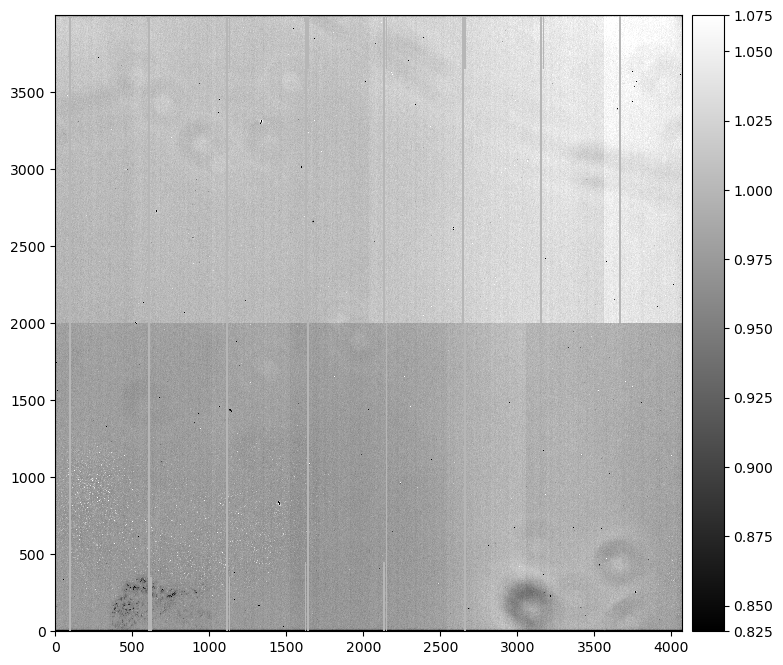

In [25]:
fig = plt.figure(figsize=(10,8))
afw_display = afwDisplay.Display(frame=fig)
afw_display.scale('linear', 'zscale',None)
afw_display.mtv(test_img.image)

In [32]:
flat_data = test_img.getImage().array

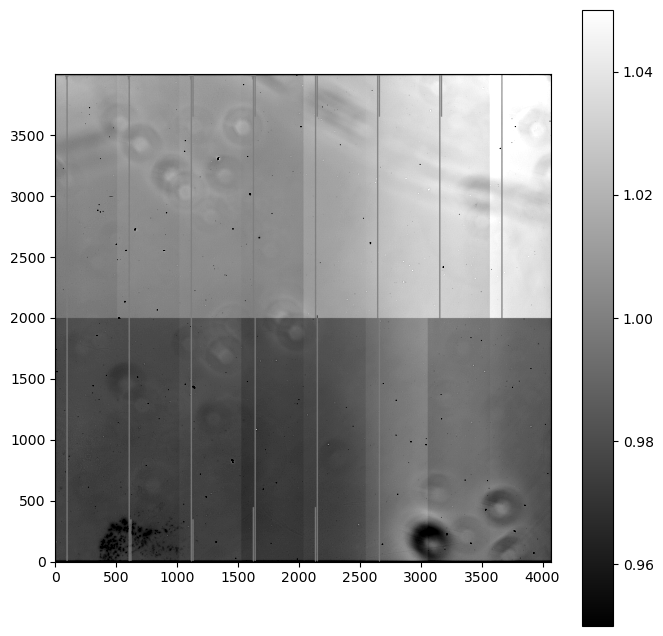

In [33]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
#im = ax.imshow(isr_test.exposure.image.array,cmap="gray",origin='lower',norm=LogNorm())
im = ax.imshow(flat_data,cmap="gray",origin='lower',vmin=0.95,vmax=1.05)
#ax.axhline(y=1000,ls='--')
#ax.set_title('Pseudo-postISRCCD')
fig.colorbar(im,ax=ax)

In [34]:
md = test_img.getMetadata().toDict()

# Save in fits file 

In [35]:
outdir_ = outdir_label.format(obs_day)
outdir = os.path.join(outdir_base,outdir_)
if os.path.exists(outdir)==False:
    os.mkdir(outdir)

In [37]:
filename_out = 'flat_{0}_{1}.fits'.format(obs_day,physical_filter.replace('~','-'))
fullfilename_out = os.path.join(outdir,filename_out)

print(f">>>>  output filename {filename_out}")

hdr = fits.Header()
    
for key,value in md.items():
    hdr[str(key)] = value
    

# Be carefull for Spectractor, 2 hdu units are necessary

primary_hdu = fits.PrimaryHDU(header=hdr)
image_hdu = fits.ImageHDU(flat_data)

hdu_list = fits.HDUList([primary_hdu, image_hdu])

hdu_list.writeto(fullfilename_out,overwrite=True)

>>>>  output filename flat_20230926_empty-empty.fits
